# Introduction
Here I will try to see what the minimum amount of oxygen needed by our model for growth is by limiting the oxygen exchange. Then I'll also take a look at the central carbon metabolism to see what changes and if this is as expected. Finally, if this is (somehwat) the case, I will see what the pathways are that consume this little bit of oxygen that is supplied.

In [1]:
import cameo
import pandas as pd
import cobra.io
from escher import Builder
import numpy
from cobra import Metabolite,Reaction
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
model = cobra.io.read_sbml_model('../model/g-thermo.xml')

In [22]:
model_e_coli = cameo.load_model('iML1515')

In [7]:
#this reaction is wrong: the e.c. number associated to it doesn't convert hydrogen peroxide.
#the correct reaction is the COOR reaction we already have. 
#as this reaction is wrong, and it will produce oxygen we need to delete it!
model.remove_reactions(model.reactions.H202OR)

C:\Users\vivmol\AppData\Local\Continuum\anaconda3\envs\g-thermo\lib\site-packages\cobra\core\model.py:716: UserWarning:

need to pass in a list



In [14]:
#save&commit
cobra.io.write_sbml_model(model,'../model/g-thermo.xml')

In [8]:
#then write a script to add different intervals of O2, and when biomass is regained print the number
O2 = list(numpy.linspace(0,1,11)) #list of oxygen exchanges to test
O2_growth = []
with model:
    #first remove the oxygen supply from the medium
    model.reactions.EX_o2_e.bounds = (0,0)
    for oxygen in O2: #iterate through each oxygen amount
        model.reactions.EX_o2_e.bounds = (-oxygen,0)
        growth = model.optimize().objective_value
        if growth > 0.01: #leaving just as zero will allow 10^-29 to be seen as growth too.
            O2_growth.append(oxygen) #store all the oxygen amounts at which the strain can still grow here
        else: 
            continue
    print (min(O2_growth))

0.1


We can iterate through the above code to find the minimal amount of oxygen needed, for different minimal growth rates.

In [251]:
#then write a script to add different intervals of O2, and when biomass is regained print the number
O2 = list(numpy.linspace(0.0015,0.002,31)) #list of oxygen exchanges to test
O2_growth = []
with model:
    #first remove the oxygen supply from the medium
    model.reactions.EX_o2_e.bounds = (0,0)
    for oxygen in O2: #iterate through each oxygen amount
        model.reactions.EX_o2_e.bounds = (-oxygen,0)
        growth = model.optimize().objective_value
        if growth > 0.12: #leaving just as zero will allow 10^-29 to be seen as growth too. 
            #here the question is what do we define as growth
            O2_growth.append(oxygen) #store all the oxygen amounts at which the strain can still grow here
        else: 
            continue
    print (min(O2_growth))

0.0017833333333333334


In [252]:
#plot the different definitions of growth with the minimal oxygen requirement
growth_def = [0.001, 0.01, 0.05, 0.1, 0.12, 0.15, 0.2, 0.3, 0.4]
min_o2_req =[1.53e-05, 0.00015, 0.00074, 0.0015, 0.00178, 1.36, 3.97, 9.2, 15.8]

Text(0.5, 0, 'Growth rate')

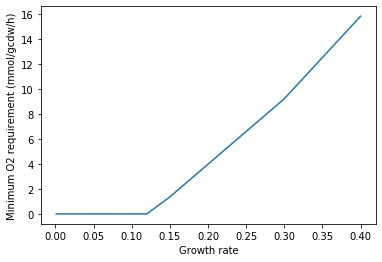

In [253]:
plt.plot(growth_def,min_o2_req)
plt.ylabel('Minimum O2 requirement (mmol/gcdw/h)')
plt.xlabel('Growth rate')

### ASPO6
This reaction produced H2O2, in the oxidation of aspartate. This step is needed as the first part for the biosynthesis of NAD. in B. subtilis (see doi 10.1111/j.1742-4658.2008.06641.x) the enzyme can use either O2 or fumurate as electron acceptor, allowing it to function in both aerobic and anaerobic conditions. the iminoaspartate can be converted with the EC 2.5.1.72, quinolinate synthase enzyme into quinolate, which can be converted further into NAD. Our model and strain has these enzymes already in it, but lacks the secondaryt reaction of the aspartate oxidase.

So here I will add it. the CAT reaction present in our model has the main function of covnerting H2O2 to detoxify the cell. As this is also oxygen dependent, it makes sense that this pathway is only triggered when oxygen is present. 


In [9]:
#add the ASPO6s reaction
model.add_reaction(Reaction(id='ASPO6s', name = 'L-aspartate:succinate oxidoreductase'))

In [10]:
model.groups.get_by_id('00760 - Nicotinate and nicotinamide metabolism').add_members(model.reactions.ASPO6s)

C:\Users\vivmol\AppData\Local\Continuum\anaconda3\envs\g-thermo\lib\site-packages\cobra\core\group.py:93: UserWarning:

need to pass in a list



In [11]:
model.reactions.ASPO6s.gene_reaction_rule = 'RTMO06195'

In [12]:
model.reactions.ASPO6s.annotation['sbo'] = 'SBO:0000176'
model.reactions.ASPO6s.annotation['ec-code'] = '1.4.3.16'

In [13]:
model.reactions.ASPO6s.add_metabolites({
    model.metabolites.asp__L_c:-1,
    model.metabolites.iasp_c:1,
    model.metabolites.succ_c:1,
    model.metabolites.fum_c:-1,
    model.metabolites.h_c: 1
})

### PPPGO_1
This reaction also produces H2O2, but there is only evidence that this is the only way this reaction can occur. SO i will leave it. This enzyme is required in the Porphyrin and chlorophyll metabolism, which in our model is crucial for the formation of protoheme and hemeO that is in our biomass reaction. So this will be left as it is. 

## change in demand @ 0.12 h-1
from the graph we made above, we can see a clear change in the minimum oxygen requirement need to sustain growth around the 0.15 h-1 node. Now I will try to investigate what changes here at this node. It can give us important insights.

Spotted an error: when we remove oxygen from the strain, we produce a lot of butyrate. After a bit of investigation, we see this is because of the ACOAD1 reaction that is present in the model. Digging a bit further, we see that there is no annotation for the NAD dependent version, so this will be removed.

In [13]:
model.remove_reactions(model.reactions.ACOAD1)

C:\Users\vivmol\AppData\Local\Continuum\anaconda3\envs\g-thermo\lib\site-packages\cobra\core\group.py:110: UserWarning:

need to pass in a list



In [13]:
model.reactions.EX_o2_e.bounds = (-0.00178,0)

In [14]:
#make a script to find each reaction involving oxygen and the flux through it (only if it is larger than 0)
rct_O2 = []
flux_O2_low = []
desc_O2 = []
flux_perc_low = []
solution = model.optimize()
for rct in model.metabolites.o2_c.reactions:
    flux = solution[rct.id]
    rct_O2.append(rct.id)
    flux_O2_low.append(flux)
    desc_O2.append(rct.reaction)
    flux_perc_low.append(100*flux/0.00178)

In [15]:
#make a dataframe
df_O2_low = pd.DataFrame({'ID': rct_O2, 'Flux_0.12': flux_O2_low, 'Flux_0.12 %':flux_perc_low,'Description': desc_O2} )

In [16]:
#repeat for the oxygen supply at growth rate 0.15
model.reactions.EX_o2_e.bounds = (-1.36,0)
rct_O2_high = []
flux_O2_high = []
flux_perc_high = []
solution = model.optimize()
for rct in model.metabolites.o2_c.reactions:
    flux = solution[rct.id]
    rct_O2_high.append(rct.id)
    flux_O2_high.append(flux)
    flux_perc_high.append(100*flux/1.36)

In [17]:
#make a dataframe for the higher amount
df_O2_high = pd.DataFrame({'ID': rct_O2_high, 'Flux_0.15': flux_O2_high, 'Flux_0.15 %':flux_perc_high} )

In [18]:
#merge two based on rct id
df_combine = pd.merge(df_O2_low, df_O2_high, on='ID')

In [19]:
df_combine = df_combine[['ID', 'Description', 'Flux_0.12 %', 'Flux_0.15 %']]

In [20]:
#remove lines where the flux is zero in both cases
for index, row in df_combine.iterrows():
    flux_1 = row['Flux_0.12 %']
    flux_2 = row['Flux_0.15 %']
    if flux_1 ==0:
        if flux_2 == 0:
            df_combine = df_combine.drop([index])
        else: continue
    else:
        continue

In [21]:
df_combine

,ID,Description,Flux_0.12 %,Flux_0.15 %
0,CAT,2.0 h2o2_c --> 2.0 h2o_c + o2_c,5.938731,0.009670
1,PMES,2.0 fmnh2_c + 3.0 o2_c + palmACP_c --> 2.0 fmn...,0.012114,0.000020
3,GLYHOR,gly_c + o2_c --> dhgly_c + h2o2_c,1.350675,0.002199
8,ACDO,dhmtp_c + o2_c --> 4met2obut_c + for_c + 2.0 h_c,41.186509,0.067065
10,O2t,o2_e <=> o2_c,100.000000,100.000000
11,BLUB,fmnh2_c + o2_c --> diur_c + dmbzid_c + e4p_c +...,1.350675,0.002199
12,CYTBO3,2.5 h_c + 0.5 o2_c + qh2_c --> h2o_c + 2.5 h_e...,0.000000,199.674335
14,GLYCTO1,glyclt_c + o2_c --> glx_c + h2o2_c,2.422736,0.003945
19,FERO,4.0 fe2_c + 4.0 h_c + o2_c --> 4.0 fe3_c + 2.0...,51.487743,0.083839
21,PPPGO_1,3.0 o2_c + pppg9_c --> 3.0 h2o2_c + ppp9_c,2.701350,0.004399


With the above knowledge, i will now try to see if we supplement it into the medium: can we then achieve anaerobic growth?

list of metabolites: 
Biotin, thiamine, spermidine, spermine, cobalamin (vitB12), tetra-hydro-folate (THF), Fe(III), protoheme and heme O

In [133]:
with model:
    #add supply reactions for each of the metabolites identified, as sink reactions
    model.add_boundary(model.metabolites.btn_c, type = 'sink', reaction_id = 'sink_btn')
    model.add_boundary(model.metabolites.thmpp_c , type = 'sink', reaction_id = 'sink_thmpp')
    model.add_boundary(model.metabolites.sprm_c, type = 'sink', reaction_id = 'sink_sprm')
    model.add_boundary(model.metabolites.spmd_c, type = 'sink', reaction_id = 'sink_spmd')
    model.add_boundary(model.metabolites.adocbl_c, type = 'sink', reaction_id = 'sink_adocbl')
    model.add_boundary(model.metabolites.get_by_id('10fthf_c') , type = 'sink', reaction_id = 'sink_10fthf')
    model.add_boundary(model.metabolites.fe3_c , type = 'sink', reaction_id = 'sink_fe3')
    model.add_boundary(model.metabolites.pheme_c , type = 'sink', reaction_id = 'sink_pheme')
#     model.add_boundary(model.metabolites.hemeO_c , type = 'sink', reaction_id = 'sink_hemeO')
    #set to anaerobic
    model.reactions.EX_o2_e.bounds = (0,0)
    solution = model.optimize()
    print('Growth rate:', round(solution.objective_value,3),'/h')
    print('Biotin:','{:0.2e}'.format(abs(solution['sink_btn'])),' mmol/gCDW/h')
    print('Thiamine diphosphate:','{:0.2e}'.format(abs(solution['sink_thmpp'])),' mmol/gCDW/h')
    print('Spermine:','{:0.2e}'.format(abs(solution['sink_sprm'])),' mmol/gCDW/h')
    print('Spermidine:','{:0.2e}'.format(abs(solution['sink_spmd'])),' mmol/gCDW/h')
    print('VitB12:','{:0.2e}'.format(abs(solution['sink_adocbl'])),' mmol/gCDW/h')
    print('10-Formyltetrahydrofolate:','{:0.2e}'.format(abs(solution['sink_10fthf'])),' mmol/gCDW/h')
    print('Iron(III):','{:0.2e}'.format(abs(solution['sink_fe3'])),' mmol/gCDW/h')
    print('protoheme:','{:0.2e}'.format(abs(solution['sink_pheme'])),' mmol/gCDW/h')
#     print('Heme O:',solution['sink_hemeO'])
    print ('Oxygen uptake:', '{:0.2e}'.format(abs(solution['EX_o2_e'])),' mmol/gCDW/h')
    
    

Growth rate: 0.124 /h
Biotin: 2.22e-07  mmol/gCDW/h
Thiamine diphosphate: 2.48e-05  mmol/gCDW/h
Spermine: 3.11e-04  mmol/gCDW/h
Spermidine: 1.33e-04  mmol/gCDW/h
VitB12: 2.48e-05  mmol/gCDW/h
10-Formyltetrahydrofolate: 4.44e-05  mmol/gCDW/h
Iron(III): 3.78e-03  mmol/gCDW/h
protoheme: 4.95e-05  mmol/gCDW/h
Oxygen uptake: 0.00e+00  mmol/gCDW/h


In [4]:
model.metabolites.ppp9_c.annotation

{'sbo': 'SBO:0000247',
 'bigg.metabolite': 'ppp9',
 'biocyc': 'META:PROTOPORPHYRIN_IX',
 'chebi': ['CHEBI:15430',
  'CHEBI:14961',
  'CHEBI:26358',
  'CHEBI:8592',
  'CHEBI:14960',
  'CHEBI:14959',
  'CHEBI:36159',
  'CHEBI:57306'],
 'hmdb': 'HMDB00241',
 'inchi_key': 'KSFOVUSSGSKXFI-UJJXFSCMSA-L',
 'kegg.compound': 'C02191',
 'metanetx.chemical': 'MNXM346',
 'reactome.compound': ['189487', '189463'],
 'sabiork': '6061',
 'seed.compound': 'cpd01476'}

In [ ]:
*